### Pre-processing

In [19]:
from util import *

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle

from scipy import stats
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.decomposition import PCA
from joblib import dump, load

In [2]:
data_log, data_dash = get_data_frames()
result_total, labels = get_data_concated(data_log, data_dash)

### Models

In [13]:
def train_rf_model(features_train: pd.DataFrame, labels_train: pd.Series):
    X_train, X_validation, y_train, y_validation = train_test_split(
        features_train,
        np.ravel(labels_train),
        test_size=0.20,
        random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_validation_scaled = scaler.transform(X_validation)

    rf_model = RandomForestRegressor(
        n_estimators=140,
        max_depth=80,
        min_samples_split=10,
        min_samples_leaf=5,
        bootstrap=True,
        verbose=1,
        max_features='sqrt',
        n_jobs=-1,
        random_state=42
    )

    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = cross_val_score(
        rf_model,
        X_train_scaled,
        y_train,
        cv=kf,
        scoring=mae_scorer
    )

    avg_cv_score = np.mean(cv_scores)

    rf_model.fit(X_train_scaled, y_train)

    y_pred_rf = rf_model.predict(X_validation_scaled)
    mae_rf = mean_absolute_error(y_validation, y_pred_rf)
    nmae_rf = mae_rf / np.mean(y_validation)

    feature_importances = rf_model.feature_importances_
    print(feature_importances)

    return nmae_rf, rf_model

### Train

In [14]:
nmae_rf, rf_model = train_rf_model(result_total, labels)
print(f"{nmae_rf*100:.4f}%")
alert_end()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 140 out of 140 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 140 out of 140 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.3s
[Parall

[0.10491887 0.09557231 0.06410275 0.00024782 0.02928518 0.00040802
 0.10766915 0.10792959 0.0641318  0.02246447 0.02733227 0.02109477
 0.09861331 0.11396112 0.06588622 0.0243143  0.02808612 0.02398195]
28.3283%


[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 140 out of 140 | elapsed:    0.1s finished
/home/kilmer/Development/data-science/search-telemetry-service-estimation/.env/lib/python3.12/site-packages/plyer/platforms/linux/notification.py:103: UserWarning: The Python dbus package is not installed.
Try installing it with your distribution's package manager, it is usually called python-dbus or python3-dbus, but you might have to try dbus-python instead, e.g. when using pip.
  warnings.warn(msg)


In [20]:
X = result_total
Y = labels

# Imputação e remoção de atributos com valores iguais
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

def remove_same_valued_attr(df):
    return df.loc[:, df.nunique() > 1]

X_imputed = remove_same_valued_attr(X_imputed)

# Dividindo os dados
X_train, X_eval, Y_train, Y_eval = train_test_split(
    X_imputed, Y, test_size=0.2, random_state=42
)

# Pipeline e RandomizedSearchCV
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state=42))
])

param_dist = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2],
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=kf,
    scoring='neg_mean_absolute_error',  # Alterado para MAE
    random_state=42,
    n_jobs=-1,
    verbose=3
)

random_search.fit(X_train, Y_train)

# Avaliação do modelo
best_model = random_search.best_estimator_

Y_pred = best_model.predict(X_eval)

# Cálculo do NMAE
mae = mean_absolute_error(Y_eval, Y_pred)
nmae = mae / Y_eval.mean()  # Normalizando pelo valor médio

print(f'Melhor modelo: {best_model}')
print(f'Mean Absolute Error na avaliação: {mae}')
print(f'Normalized Mean Absolute Error na avaliação: {nmae}')

# Visualizações
plt.figure(figsize=(8, 6))
sns.scatterplot(x=Y_eval, y=Y_pred)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('Valores Reais vs Preditos')
plt.show()

importances = best_model.named_steps['regressor'].feature_importances_
feature_names = X_imputed.columns
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Importância das Features')
plt.show()


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 3/5] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=50;, score=-77.390 total time=  12.7s
[CV 1/5] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=50;, score=-76.255 total time=  13.1s
[CV 2/5] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=50;, score=-75.491 total time=  13.2s
[CV 4/5] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=50;, score=-80.624 total time=  13.4s
[CV 5/5] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=50;, score=-95.971 total time=  11.6s
[CV 2/5] END regressor__max_depth=20, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators

/home/kilmer/Development/data-science/search-telemetry-service-estimation/.env/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


NameError: name 'mean_squared_error' is not defined

Melhor modelo: Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 RandomForestRegressor(max_depth=20, min_samples_leaf=2,
                                       random_state=42))])
Mean Absolute Error na avaliação: 5.858696096494347
Normalized Mean Absolute Error na avaliação: 0.29101955956263614


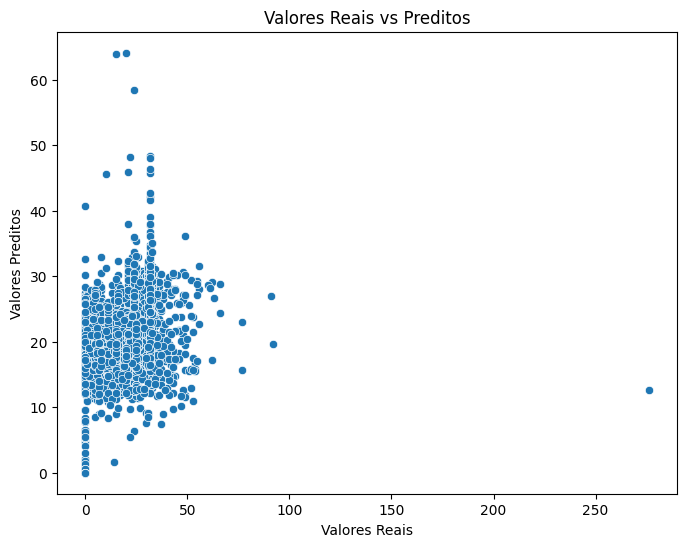

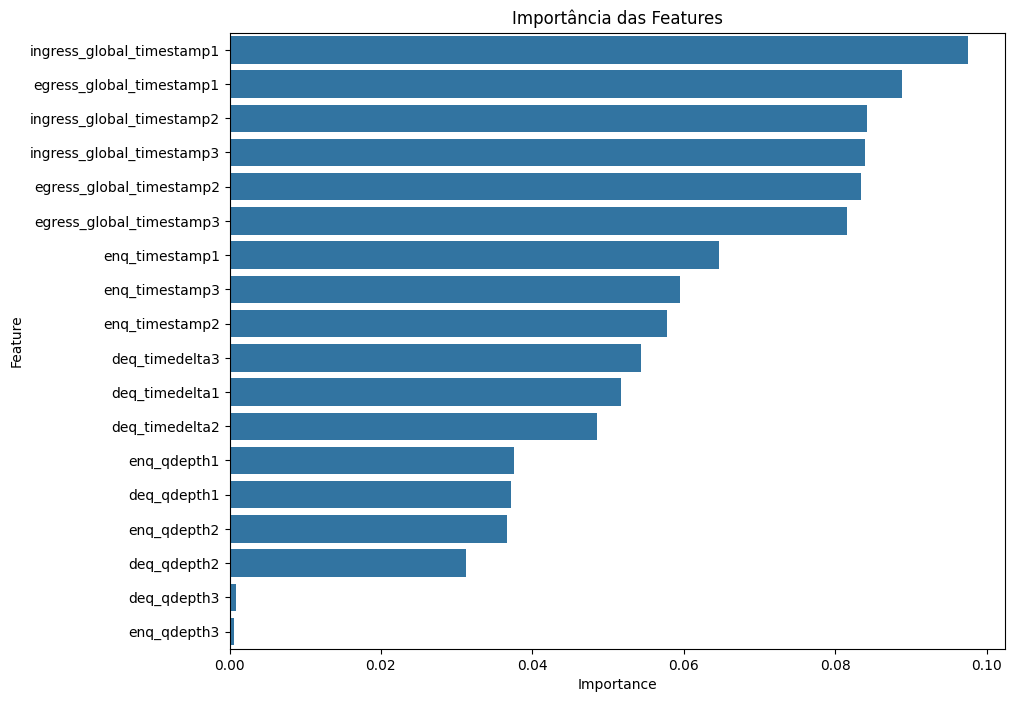

In [21]:
mae = mean_absolute_error(Y_eval, Y_pred)
nmae = mae / Y_eval.mean()  # Normalizando pelo valor médio

print(f'Melhor modelo: {best_model}')
print(f'Mean Absolute Error na avaliação: {mae}')
print(f'Normalized Mean Absolute Error na avaliação: {nmae}')

# Visualizações
plt.figure(figsize=(8, 6))
sns.scatterplot(x=Y_eval, y=Y_pred)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('Valores Reais vs Preditos')
plt.show()

importances = best_model.named_steps['regressor'].feature_importances_
feature_names = X_imputed.columns
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Importância das Features')
plt.show()
